In [1144]:
import matplotlib.pyplot as plt
import math
import torch
import V1_DAE as V1
import V1_DAE_v2 as V2
import NR
import importlib
import FitzNag as FN
import DAE_solver as DS
from data_generator import *
import torchvision
import torchvision.datasets as datasets

In [641]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.set_device(0) #use GPU 1

In [642]:
#Load MNIST
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
data_load = torch.utils.data.DataLoader(mnist_trainset, shuffle = True)

In [643]:
mov_len = 5
images = data_load.dataset.data[0:1000].numpy()
M = rand_trans(images, 1, 3)
data_mov = torch.from_numpy(image_gen(images,M, mov_len)).float().cuda()
data_mov = data_mov/255

In [646]:
data_mov.shape

torch.Size([1000, 5, 28, 28])

In [644]:
importlib.reload(V1)

<module 'V1_DAE' from '/home/shazoop/form-and-motion/EE219A/V1_DAE.py'>

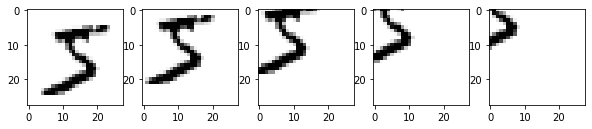

In [647]:
fig =  plt.figure(figsize= (10,10) )
for i in range(mov_len):
    fig.add_subplot(1,mov_len, i + 1)
    plt.imshow(data_mov[0,i,:].cpu().numpy(), cmap = 'Greys')

In [2732]:
main = V2.fullV1(a=  .8, b=.3, tau = 10)

In [2733]:
main.summary()

['In the hidden layer, there are 25 units per slice, with depth 16, and RF size: 12 by 12',
 'In the top layer, there are 16 units',
 'There are 400 hidden units, 16 top units, and 1632 units in total.',
 'Fitz-Nag parameters (a,b, tau) are (0.8,0.3, 10).',
 'Self-activation parameter is 0.5']

In [2734]:
x, funargs= main.init()

In [2735]:
Input = torch.rand(28,28)

In [2736]:
#Test run. SInce linear, should converge in 1 step for NR.
f = lambda x ,funargs: torch.tensor([[3,0],[0,1]]).float() @ x
df = lambda x, funargs: torch.tensor([[3,0],[0,1]]).float()
xinit = torch.tensor([0,0]).float()
NR.NR(f,df,xinit, [])

(tensor([0., 0.]), 1, 1)

In [2765]:
importlib.reload(FN)
importlib.reload(DS)

<module 'DAE_solver' from '/home/shazoop/form-and-motion/EE219A/DAE_solver.py'>

In [2766]:
fitz = FN.FN(n = 1, tau= 10)

In [2767]:
fitz.print_parms()

{'# neurons': 1, 'a': 0.7, 'b': 0.8, 'tau': 10}


In [2768]:
x = fitz.init()

In [2769]:
u = 3*torch.ones(1).float()

In [2770]:
DSsolve = DS.DAE_solver(fitz,x,u, funargs = [], h = .1, tstop = 10, method = 'BE')

In [2771]:
tpts, xpts = DSsolve.solve()

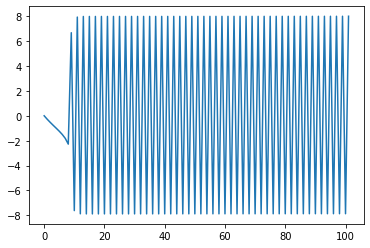

In [2772]:
plt.plot(xpts[:,0].cpu().numpy())

In [2753]:
xpts.shape

torch.Size([102, 2])

In [3704]:
importlib.reload(V1)
importlib.reload(DS)
importlib.reload(V2)

<module 'V1_DAE_v2' from '/home/shazoop/form-and-motion/EE219A/V1_DAE_v2.py'>

In [3795]:
main = V1.fullV1(tau = 50, lam = .5)

In [3796]:
main.print_allparms()

{'pixel dim': 28,
 'RF 1 dim': 12,
 'hidden layer depth': 16,
 'top layer depth': 16,
 'L1 stride': 4,
 'self-activate  parameter': 0.5,
 'a': 0.7,
 'b': 0.8,
 'tau': 50}

In [3797]:
main.summary()

['In the hidden layer, there are 25 units per slice, with depth 16, and RF size: 12 by 12',
 'In the top layer, there are 16 units',
 'There are 400 hidden units, 16 top units, and 1248 units in total.',
 'Fitz-Nag parameters (a,b, tau) are (0.7,0.8, 50).',
 'Self-activation parameter is 0.5']

In [3798]:
x, funargs = main.init()

In [3799]:
# N,n1,d1,d2,S1, lam, a, b, tau = main._parms.values()
# itau = 1/tau
# L1_dim = int((N+S1-n1)/S1) #one-sided: number of units
# L1sq = int(L1_dim**2)
# N1 = L1sq*d1
# N2 = d2
# ttlN = 3*N1 + 3*N2
# y,v,w,v_z,w_z,z = main.getVars(x)
# W,A = funargs

# Q = torch.zeros(N1,N1)
# Q1 = (torch.ones(d1,d1) - lam*torch.eye(d1))
# for i in range(L1sq):
#     Q[i*d1:(i+1)*d1, i*d1:(i+1)*d1] = Q1
# J[:N1,:N1] = torch.diag(V1.drelu(V1.logG(u) - Q @ y)) @ (-Q) - torch.eye(N1)  


In [3800]:
u = main.uMul(data_mov[1,0],funargs)

In [3818]:
DSsolve = DS.DAE_solver(main,x,u, funargs = funargs, h = .05, tstop = 8, method = 'BE', \
                        NRparms = {'maxiter': 200, 'reltol': 1e-3, 'abstol': 1e-3, 'restol': 1e-4, 'convcrit': 'dxORres' })

In [3819]:
_,xpts = DSsolve.solve()


NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 4.249999999999993, step 85


In [3820]:
y,v,w,v_z,w_z,z = main.getVars(xpts[len(xpts)-1])

In [3821]:
ix = y.argmax().item()

In [3822]:
y.shape

torch.Size([400])

(array([323.,  23.,  22.,  11.,  10.,   2.,   5.,   3.,   0.,   1.]),
 array([1.6347830e-04, 2.9085225e-01, 5.8154100e-01, 8.7222975e-01,
        1.1629186e+00, 1.4536073e+00, 1.7442961e+00, 2.0349848e+00,
        2.3256736e+00, 2.6163623e+00, 2.9070511e+00], dtype=float32),
 <a list of 10 Patch objects>)

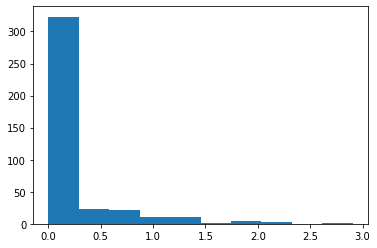

In [3823]:
plt.hist(y.cpu().numpy())
#plt.savefig('Model2_y')

In [3824]:
z

tensor([ 3.4322e-01,  3.4327e-01,  2.4116e-01, -4.4877e-15,  1.0590e-01,
        -4.4904e-15,  2.4868e-02, -4.4877e-15,  2.5451e-02,  2.4079e-01,
        -1.4250e-14,  1.9778e-02, -4.4877e-15,  3.4244e-01,  2.1285e-01,
         2.4741e-02])

In [3825]:
#1/len(xpts)*(xpts[:,400:800]**2).sum(dim=0)

In [3826]:
#1/len(xpts)*xpts[:,400:800].clamp(min=0).sum(dim=0)

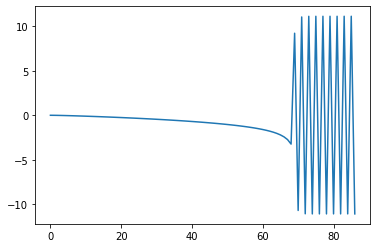

In [3827]:
plt.plot(xpts[:,ix+400].cpu().numpy())
#plt.savefig('Model2_v')

In [3828]:
v_z.argmax()

tensor(2)

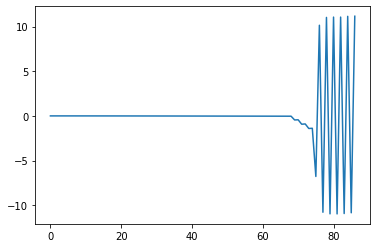

In [3829]:
plt.plot(xpts[:,13+1200].cpu().numpy())
#plt.savefig('Model2_vz')

(array([9., 0., 0., 1., 0., 0., 1., 2., 0., 3.]),
 array([-1.4249908e-14,  3.4327008e-02,  6.8654016e-02,  1.0298103e-01,
         1.3730803e-01,  1.7163505e-01,  2.0596206e-01,  2.4028906e-01,
         2.7461606e-01,  3.0894309e-01,  3.4327009e-01], dtype=float32),
 <a list of 10 Patch objects>)

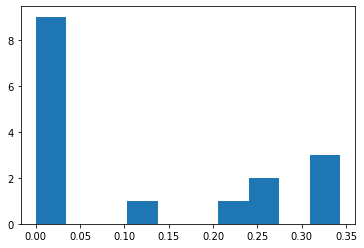

In [3830]:
plt.hist(z.cpu().numpy())
#plt.savefig('Model2_z')

In [3814]:
ix = y.argmax().item()

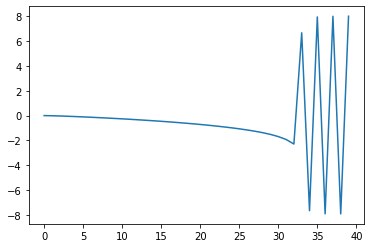

In [3815]:
plt.plot(xpts[:,ix+400].cpu().numpy())

In [3296]:
x_final2[400:800].sum(dim=0)

NameError: name 'x_final2' is not defined

In [ ]:
plt.plot(xpts[:,8+1200].cpu().numpy())

In [2846]:
torch.max(1/102*(xpts[:,400:800].abs()).sum(dim=0))

tensor(4.4127)

In [3787]:
importlib.reload(DS)
importlib.reload(V1)

<module 'V1_DAE' from '/home/shazoop/form-and-motion/EE219A/V1_DAE.py'>

In [3831]:
main = V1.fullV1(tau = 50, lam = .5)
main.summary()

['In the hidden layer, there are 25 units per slice, with depth 16, and RF size: 12 by 12',
 'In the top layer, there are 16 units',
 'There are 400 hidden units, 16 top units, and 1248 units in total.',
 'Fitz-Nag parameters (a,b, tau) are (0.7,0.8, 50).',
 'Self-activation parameter is 0.5']

In [3832]:
N, L1,d1,d2 = main.print_parms()

trainSteps = 500
par1 = .3
par2 = .3
par3 = .2

In [3835]:
x, funargs = main.init()
W,A = funargs

In [ ]:
for train in range(trainSteps):
    input_mov = data_mov[int(np.random.randint(0,data_mov.size(0),1))] #select a random movie sequence
    x = main.xinit()
    for i in range(mov_len):
        uPix = main.pixel_mask(input_mov[i])
        u = main.uMul(input_mov[i],funargs)
        DSsolve = DS.DAE_solver(main,x,u, funargs = funargs, h = .05, tstop = 7, method = 'BE', \
                        NRparms = {'maxiter': 200, 'reltol': 1e-3, 'abstol': 1e-3, 'restol': 1e-4, 'convcrit': 'dxORres' })
        _,xpts = DSsolve.solve()
        y,v,w,v_z,w_z,z = main.getVars(xpts[len(xpts)-1])
        T = len(xpts)
        v_trace = 1/T*(xpts[:,400:800].clamp(min=0)).sum(dim=0) #average positive part
        if i == 0:
            z_avg = z
        else:
            z_avg = (1-par3)*z_avg + par3*z
        v_in = v_trace.reshape(L1,L1,d1)
        dW = torch.einsum('abc,abn -> abcn', v_in,uPix) - torch.einsum('abc,abcn -> abcn', v_in, W )
        W = W + par1*dW
        dA = torch.einsum('i,j -> ij', z_avg,v_trace) - torch.einsum('i,ij -> ij',z_avg,A)
        A = A + par2*dA
        x = xpts[len(xpts)-1]
        funargs = (W,A)
    print(train)
        
        
        
        




NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 0.8000000000000002, step 16

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 0.44999999999999996, step 9

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 0.3, step 6

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 0.5499999999999999, step 11
0

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 5.799999999999987, step 116

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 0.15000000000000002, step 3

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 3.649999999999995, step 73

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 0.9000000000000002, step 18

NR failed to solve nonlinear equations - reached maxit


NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 0, step 0
14

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 3.7999999999999945, step 76


In [3753]:
#W_F,A_F = funargs

In [3776]:
W,A=funargs

/home/shazoop/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/shazoop/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/shazoop/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/shazoop/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/shazoop/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:885: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/shazoop/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False

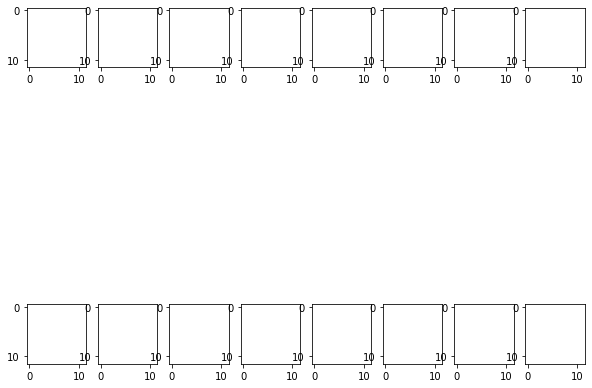

In [3777]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(W[0,0,i,:].reshape(12,12).cpu().numpy(),cmap='Greys')

In [3657]:
y,v,w,v_z,w_z,z = main.getVars(xpts[len(xpts)-1])

In [3658]:
ix = y.argmax().item()

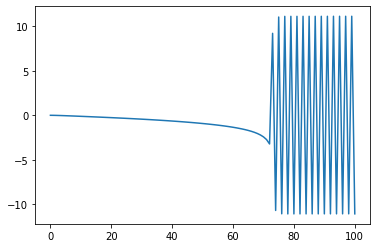

In [3659]:
plt.plot(xpts[:,ix+400].cpu().numpy())

In [2872]:
        v_trace = 1/T*(xpts[:,400,800]**2).sum(dim=0) #average power


IndexError: too many indices for tensor of dimension 2

In [ ]:
torch.cat((torch.cat((a,b), dim = 0),c), dim = 0)

In [ ]:
C  = torch.stack((a,b))

In [ ]:
a